## 1. Identificación del Problema

El problema específico es la alta tasa de deserción de clientes en el sector de telecomunicaciones en la India. Esto implica que los clientes abandonan sus servicios actuales para cambiarse a otros proveedores.

## 2. Relevancia del Problema

Este problema es relevante porque una alta tasa de deserción afecta la rentabilidad y sostenibilidad de las empresas de telecomunicaciones. Además, entender los factores que influyen en la fidelidad de los clientes puede ayudar a mejorar los servicios y la satisfacción del cliente.

## 3. Objetivos Específicos

#### Los objetivos concretos son:

	•	Identificar los principales factores que contribuyen a la deserción de clientes.
	•	Desarrollar un modelo predictivo que pueda predecir con precisión la probabilidad de deserción de un cliente.
	•	Proporcionar recomendaciones basadas en los hallazgos para reducir la tasa de churn.

## 5. Preguntas de Investigación

#### Las preguntas de investigación podrían ser:

	•	¿Qué factores demográficos y de comportamiento están más asociados con la deserción de clientes?
	•	¿Cómo varía la tasa de churn entre diferentes proveedores de telecomunicaciones?

## 6. Hipótesis Iniciales o Suposiciones

##### Una hipótesis inicial podría ser que factores como el costo del plan, la calidad del servicio y la edad del cliente influyen significativamente en la deserción.

## 7. Potenciales Desafíos y Limitaciones

#### Los desafíos podrían incluir:

	•	La calidad y completitud de los datos.
	•	Interpretar correctamente las complejas interacciones entre diferentes variables.
	•	La generalización de los resultados a toda la población de clientes.

## 8. Planificación Preliminar y Distribución del Trabajo

#### El trabajo se podría organizar en varias fases:

	•	Análisis exploratorio y preparación de datos.
	•	Desarrollo y validación de modelos predictivos.
	•	Análisis de resultados y formulación de recomendaciones.
	•	La distribución del trabajo dependerá de las habilidades del equipo, como análisis de datos, modelado estadístico y 
		experiencia en telecomunicaciones.


Variable 		   : Description

**customer_id**  	   : Unique identifier for each customer.

**telecom_partner**   : The telecom partner associated with the customer.

**gender**             : The gender of the customer.

**age** 			  : The age of the customer.

**state**			   : The Indian state in which the customer is located.

**city**			   : The city in which the customer is located.

**pincode**		   : The pincode of the customer's location.

**registration_event** : When the customer registered with the telecom partner.

**num_dependents** : The number of dependents (e.g., children) the customer has.

**estimated_salary**   : The customer's estimated salary.




In [4]:
#!pip install seaborn
#!pip install pandas 
#!pip install numpy
#!pip install matplotlib  

In [5]:
#Importamos las librerías princiaples
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#Lectura de los archivos .csv con pandas
df1 = pd.read_csv('telecom_demographics.csv')
df2 = pd.read_csv('telecom_usage.csv')

In [7]:
#Unimos los dos dataframes con la variable customer id
df_full = pd.merge(df1,df2,on='customer_id')
df_full

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,78836,Airtel,M,54,Odisha,Chennai,125785,2021-01-29,4,124805,-2,39,5000,0
6496,146521,BSNL,M,69,Andhra Pradesh,Hyderabad,923076,2022-01-03,1,65605,20,31,3562,0
6497,40413,Airtel,M,19,Gujarat,Hyderabad,152201,2020-07-21,0,28632,73,14,65,0
6498,64961,Vodafone,M,26,Meghalaya,Chennai,782127,2020-11-21,3,119757,52,8,6835,0


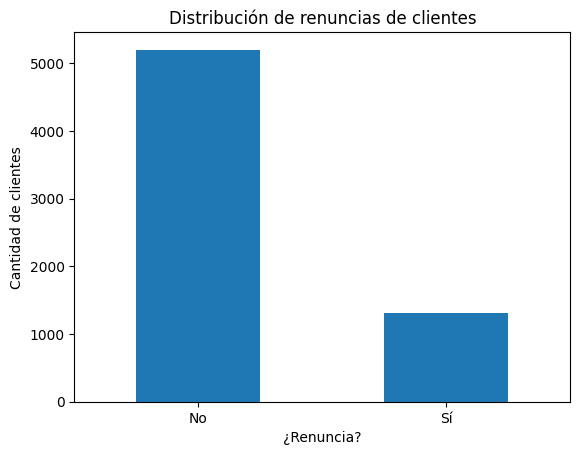

In [8]:
churn_counts = df_full['churn'].value_counts().replace({0: 'No', 1: 'Sí'})

# Crear un gráfico de barras
churn_counts.plot(kind='bar')

# Configurar etiquetas
plt.xlabel('¿Renuncia?')
plt.ylabel('Cantidad de clientes')
plt.title('Distribución de renuncias de clientes')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)

# Mostrar el gráfico
plt.show()

In [9]:
df_full.groupby('telecom_partner')['churn'].count()

telecom_partner
Airtel          1598
BSNL            1635
Reliance Jio    1658
Vodafone        1609
Name: churn, dtype: int64

In [10]:
df_full.groupby('calls_made')['churn'].count().sort_values(ascending=False)[0:10]

calls_made
86    86
83    82
89    80
70    80
38    78
87    77
90    75
47    74
9     74
16    74
Name: churn, dtype: int64

(array([ 21.,  24.,  71.,  62.,  70., 144.,  98., 118., 193., 127., 139.,
        185., 138., 164., 130., 129., 193., 133., 124., 180., 133., 129.,
        195., 116., 136., 199., 123., 196., 137., 125., 185., 132., 133.,
        198., 113., 134., 184., 118., 181., 132., 149., 218., 135., 127.,
        146.,  74.,  76.,  95.,  28.,  10.]),
 array([-10.  ,  -7.64,  -5.28,  -2.92,  -0.56,   1.8 ,   4.16,   6.52,
          8.88,  11.24,  13.6 ,  15.96,  18.32,  20.68,  23.04,  25.4 ,
         27.76,  30.12,  32.48,  34.84,  37.2 ,  39.56,  41.92,  44.28,
         46.64,  49.  ,  51.36,  53.72,  56.08,  58.44,  60.8 ,  63.16,
         65.52,  67.88,  70.24,  72.6 ,  74.96,  77.32,  79.68,  82.04,
         84.4 ,  86.76,  89.12,  91.48,  93.84,  96.2 ,  98.56, 100.92,
        103.28, 105.64, 108.  ]),
 <BarContainer object of 50 artists>)

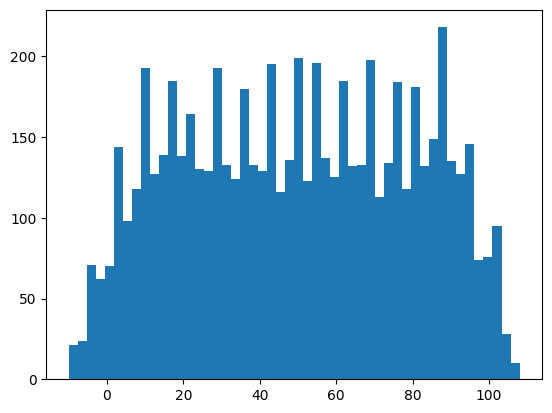

In [11]:
plt.hist(df_full['calls_made'], bins=50)

In [12]:
import seaborn as sns
import warnings 

In [13]:
df_full['churn'].value_counts()

churn
0    5197
1    1303
Name: count, dtype: int64

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


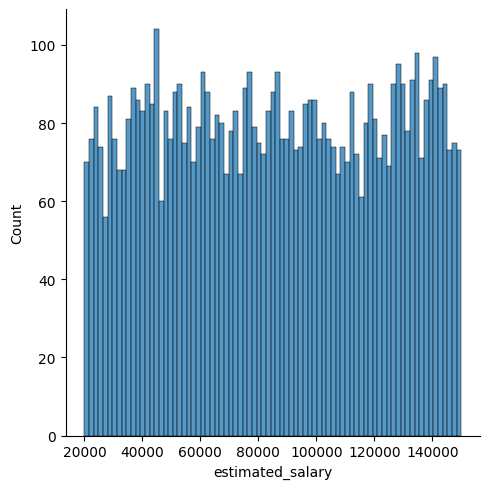

In [14]:
sns.displot(df_full['estimated_salary'], bins=81)

In [15]:
df_full.shape

(6500, 14)

In [16]:
num_bins = 14

# Calcula los límites de los bins
bin_width = (max(df_full['estimated_salary']) - min(df_full['estimated_salary'])) / num_bins
bins = [min(df_full['estimated_salary']) + i * bin_width for i in range(num_bins + 1)]


In [17]:
num_rangos = 20

# Calcula los límites de los rangos
rangos = pd.qcut(df_full['estimated_salary'], q=num_rangos, labels=False) + 1

# Crea una nueva columna con los valores de los rangos
df_full['rango'] = rangos

# Muestra el DataFrame resultante
df_full['rango']

0       11
1        8
2        9
3        3
4        2
        ..
6495    16
6496     7
6497     2
6498    16
6499    16
Name: rango, Length: 6500, dtype: int64

In [18]:
rango_df = df_full.groupby('rango')['churn'].sum().reset_index()
rango_df 

,rango,churn
0,1,64
1,2,80
2,3,83
3,4,62
4,5,65
5,6,59
6,7,65
7,8,61
8,9,70
9,10,58


c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


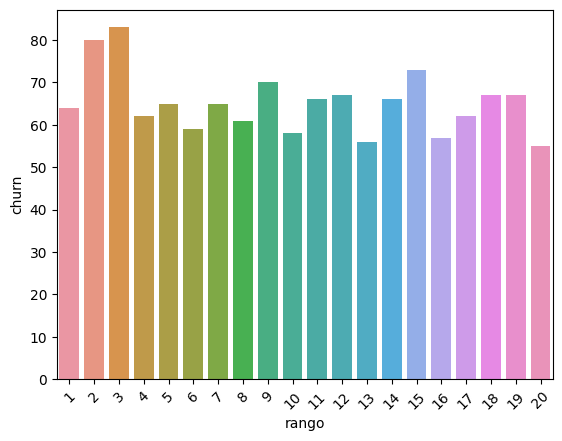

In [19]:
sns.barplot(x=rango_df['rango'], y=rango_df['churn'])
plt.xticks(rotation=45)
plt.show()

In [24]:
age_df = df_full.groupby('age')['churn'].sum().reset_index().sort_values(by='churn', ascending=False).head(10)
age_df 

,age,churn
17,35,36
45,63,35
19,37,34
38,56,31
18,36,31
30,48,30
24,42,29
37,55,29
42,60,29
39,57,28


c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


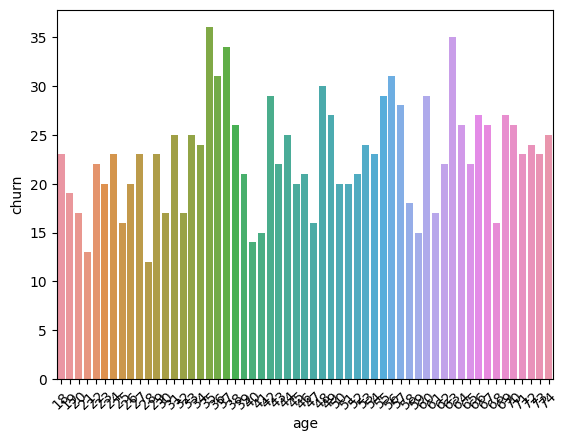

In [21]:
sns.barplot(x=age_df['age'], y=age_df['churn'])
plt.xticks(rotation=45)
plt.show()


In [22]:
df_full.columns

Index(['customer_id', 'telecom_partner', 'gender', 'age', 'state', 'city',
       'pincode', 'registration_event', 'num_dependents', 'estimated_salary',
       'calls_made', 'sms_sent', 'data_used', 'churn', 'rango'],
      dtype='object')